In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from numpy import random


import matplotlib
import matplotlib.animation as animation

from IPython.display import HTML

In [2]:
def make_initial_grid(n, prop_c_init, rand_seed, special = False):
    if special == False:
        # n*n matrix randomly 1 (C) or 0 (D)
        if rand_seed:
            random.seed(rand_seed)
        grid_strat = np.random.choice([0, 1], size=(n,n), p=[1 - prop_c_init, prop_c_init])
    else:
        grid_strat = np.ones((n, n), dtype = np.int8)
        grid_strat[round(n/2),round(n/2)] = 0

    return grid_strat

In [17]:
def play_game(player_1, player_2, t, r, p, s):
    '''
    1 (C) or 0 (D)
    both defect, both get p
    one player C one player D, D gets t
    one player C one player D, C gets s
    both players C, they both get r   
    '''
    if ((player_1 == 0) & (player_2 == 0)):
        payoff_player_1 = p
        payoff_player_2 = p
    elif ((player_1 == 0) & (player_2 == 1)):
        payoff_player_1 = t
        payoff_player_2 = s
    elif ((player_1 == 1) & (player_2 == 0)):
        payoff_player_1 = s 
        payoff_player_2 = t
    else:
        payoff_player_1 = r
        payoff_player_2 = r

    return payoff_player_1, payoff_player_2

In [4]:
def get_neighbour_strategies(grid_strat):
    
    down_neighbour = np.roll(grid_strat, -1, axis=0) # down
    up_neighbour = np.roll(grid_strat, 1, axis=0) # up
    left_neighbour = np.roll(grid_strat, -1, axis=1) # left
    right_neighbour = np.roll(grid_strat, 1, axis=1) # right
    
    nw_neighbour = np.roll(up_neighbour, -1, axis=1) # north west
    ne_neighbour = np.roll(up_neighbour, 1, axis=1) # north east
    sw_neighbour = np.roll(down_neighbour, -1, axis=1) # south west
    se_neighbour = np.roll(down_neighbour, 1, axis=1) # south east
    
    return (down_neighbour, up_neighbour, left_neighbour, right_neighbour,
            nw_neighbour, ne_neighbour, sw_neighbour, se_neighbour)

In [18]:
def get_cell_payoff(grid_strat,
                    down_neighbour,
                    up_neighbour,
                    left_neighbour,
                    right_neighbour,
                    nw_neighbour,
                    ne_neighbour,
                    sw_neighbour,
                    se_neighbour,
                    row, col, t, r, p, s):
    '''
    Where they all play the game with each other to get their total payoffs
    '''
    payoff_down_cell, _ = play_game(grid_strat[row,col], down_neighbour[row,col], t, r, p, s)
    payoff_up_cell, _ = play_game(grid_strat[row,col], up_neighbour[row,col], t, r, p, s)
    payoff_left_cell, _ = play_game(grid_strat[row,col], left_neighbour[row,col], t, r, p, s)
    payoff_right_cell, _ = play_game(grid_strat[row,col], right_neighbour[row,col], t, r, p, s)
    
    payoff_nw_cell, _ = play_game(grid_strat[row,col], nw_neighbour[row,col], t, r, p, s)
    payoff_ne_cell, _ = play_game(grid_strat[row,col], ne_neighbour[row,col], t, r, p, s)
    payoff_sw_cell, _ = play_game(grid_strat[row,col], sw_neighbour[row,col], t, r, p, s)
    payoff_se_cell, _ = play_game(grid_strat[row,col], se_neighbour[row,col], t, r, p, s)
    
    payoff_itself, _ = play_game(grid_strat[row,col], grid_strat[row,col], t, r, p, s)

    payoff = (payoff_down_cell + payoff_up_cell + payoff_left_cell + payoff_right_cell +
             payoff_nw_cell + payoff_ne_cell + payoff_sw_cell + payoff_se_cell + payoff_itself)
    

    return payoff

In [96]:
def get_cell_payoff_and_change(this_grid_strat,
                    this_down_neighbour,
                    this_up_neighbour,
                    this_left_neighbour,
                    this_right_neighbour,
                    this_nw_neighbour,
                    this_ne_neighbour,
                    this_sw_neighbour,
                    this_se_neighbour,
                    t, r, p, s):
    '''
    Alternative option where you play with your immediate neighbours and changes based on the payoffs of those games
    i.e. not based on your neighbours cumulative payoffs of all games ever
    
    Return the new strategy this cell should have
    '''
    
    # Play all the games
    
    _, payoff_down_cell = play_game(this_grid_strat, this_down_neighbour, t, r, p, s)
    _, payoff_up_cell = play_game(this_grid_strat, this_up_neighbour, t, r, p, s)
    _, payoff_left_cell = play_game(this_grid_strat, this_left_neighbour, t, r, p, s)
    _, payoff_right_cell = play_game(this_grid_strat, this_right_neighbour, t, r, p, s)
    
    _, payoff_nw_cell = play_game(this_grid_strat, this_nw_neighbour, t, r, p, s)
    _, payoff_ne_cell = play_game(this_grid_strat, this_ne_neighbour, t, r, p, s)
    _, payoff_sw_cell = play_game(this_grid_strat, this_sw_neighbour, t, r, p, s)
    _, payoff_se_cell = play_game(this_grid_strat, this_se_neighbour, t, r, p, s)
    
    _, payoff_itself = play_game(this_grid_strat, this_grid_strat, t, r, p, s)
    
    # Whose is highest?

    # All the surrounding payoffs and your own
    b = np.array([payoff_down_cell,
                 payoff_up_cell,
                 payoff_left_cell,
                 payoff_right_cell,
                 payoff_nw_cell,
                 payoff_ne_cell,
                 payoff_sw_cell,
                 payoff_se_cell,
                 payoff_itself])

    # Get the index of the highest
    best_index = np.random.choice(np.flatnonzero(b == b.max())) # if the same pick one randomly
        

    # Save the strategy of this 'best' cell (inc yourself)

    new_grid_strat = [this_down_neighbour,
                      this_up_neighbour,
                      this_left_neighbour,
                      this_right_neighbour,
                      this_nw_neighbour,
                      this_ne_neighbour,
                      this_sw_neighbour,
                      this_se_neighbour,
                      this_grid_strat][best_index]
    
    return new_grid_strat

    

In [12]:
def get_neighbour_payoffs(grid_payoff):
    
    down_neighbour_payoff = np.roll(grid_payoff, -1, axis=0) # down
    up_neighbour_payoff = np.roll(grid_payoff, 1, axis=0) # up
    left_neighbour_payoff = np.roll(grid_payoff, -1, axis=1) # left
    right_neighbour_payoff = np.roll(grid_payoff, 1, axis=1) # right
    
    nw_neighbour_payoff = np.roll(up_neighbour_payoff, -1, axis=0) # nw
    ne_neighbour_payoff = np.roll(up_neighbour_payoff, 1, axis=0) # ne
    sw_neighbour_payoff = np.roll(down_neighbour_payoff, -1, axis=1) # sw
    se_neighbour_payoff = np.roll(down_neighbour_payoff, 1, axis=1) # se
    
    return (down_neighbour_payoff, up_neighbour_payoff, left_neighbour_payoff, right_neighbour_payoff,
           nw_neighbour_payoff, ne_neighbour_payoff, sw_neighbour_payoff, se_neighbour_payoff)


In [13]:
def get_strategy_change_code(old_strat, new_strat):
    '''
    0 = stayed as D 
    1 = stayed as C 
    2 = changed from D to C
    3 = changed from C to D
    '''
    if ((old_strat == 0) & (new_strat == 0)):
        change_code = 0
    elif ((old_strat == 0) & (new_strat == 1)):
        change_code = 2
    elif ((old_strat == 1) & (new_strat == 0)):
        change_code = 3 
    else:
        change_code = 1
    return change_code

In [117]:
def one_iteration(grid_strat, n, grid_payoff, grid_colours, t, r, p, s):
    
    # Get the neighbour's strategies:

    (down_neighbour,
     up_neighbour,
     left_neighbour,
     right_neighbour,
     nw_neighbour,
     ne_neighbour,
     sw_neighbour,
     se_neighbour) = get_neighbour_strategies(grid_strat)

    # Get every cell's payoff:

    for row in range(0,n):
        for col in range(0,n):
            grid_payoff[row, col] = get_cell_payoff(grid_strat,
                                                    down_neighbour,
                                                    up_neighbour,
                                                    left_neighbour,
                                                    right_neighbour,
                                                    nw_neighbour,
                                                    ne_neighbour,
                                                    sw_neighbour,
                                                    se_neighbour,
                                                    row, col, t, r, p, s)

    # Get the neighbour's payoffs:

    (down_neighbour_payoff,
     up_neighbour_payoff,
     left_neighbour_payoff,
     right_neighbour_payoff,
     nw_neighbour_payoff,
     ne_neighbour_payoff,
     sw_neighbour_payoff,
     se_neighbour_payoff) = get_neighbour_payoffs(grid_payoff)


    # Consider your neighbours and change if they do better

    for row in range(0,n):
        for col in range(0,n):
            
            # Get previous strategy
            old_strat = grid_strat[row, col]

            # All the surrounding payoffs and your own
            b = np.array([grid_payoff[row, col],
                          right_neighbour_payoff[row,col], left_neighbour_payoff[row,col],
                          up_neighbour_payoff[row,col], down_neighbour_payoff[row,col],
                          nw_neighbour_payoff[row,col],
                          ne_neighbour_payoff[row,col],
                          sw_neighbour_payoff[row,col],
                          se_neighbour_payoff[row,col]])

            # Get the index of the highest
            best_index = np.random.choice(np.flatnonzero(b == b.max())) # if the same pick one randomly
            
            # print out the times where there has indeed been a random choice between different strategies
            #highestindexs = np.flatnonzero(b == b.max())
            #if len(highestindexs) != 1:
            #    strats = [[grid_strat[row, col],
            #            right_neighbour[row,col], left_neighbour[row,col],
            #            up_neighbour[row,col], down_neighbour[row,col],
            #            nw_neighbour[row,col], ne_neighbour[row,col],
            #            sw_neighbour[row,col], se_neighbour[row,col]][h] for h in highestindexs]
            #    if len(list(set(strats)))!=1:
            #        print(strats)
        
            
            # Update to the strategy of this 'best' cell
            grid_strat[row, col] = [grid_strat[row, col],
                                    right_neighbour[row,col], left_neighbour[row,col],
                                    up_neighbour[row,col], down_neighbour[row,col],
                                    nw_neighbour[row,col], ne_neighbour[row,col],
                                    sw_neighbour[row,col], se_neighbour[row,col]][best_index]
            
            # Get colour matrix
            grid_colours[row, col] = get_strategy_change_code(old_strat, grid_strat[row, col])
    
    return grid_strat, grid_colours

In [27]:
def one_iteration_alt(grid_strat, n, grid_payoff, grid_colours, t, r, p, s):
    
    # Get the neighbour's strategies:

    (down_neighbour,
     up_neighbour,
     left_neighbour,
     right_neighbour,
     nw_neighbour,
     ne_neighbour,
     sw_neighbour,
     se_neighbour) = get_neighbour_strategies(grid_strat)

    new_grid_strat = np.empty((n,n,))
    new_grid_strat[:] = np.nan
    
    # Consider your neighbours and change if they do better

    for row in range(0,n):
        for col in range(0,n):
            
            # Get new strategies and save (don't update)
            new_grid_strat[row, col] = get_cell_payoff_and_change(grid_strat[row, col],
                                                        down_neighbour[row, col],
                                                        up_neighbour[row, col],
                                                        left_neighbour[row, col],
                                                        right_neighbour[row, col],
                                                        nw_neighbour[row, col],
                                                        ne_neighbour[row, col],
                                                        sw_neighbour[row, col],
                                                        se_neighbour[row, col],
                                                        t, r, p, s)
            
            # Get new colour matrix
            grid_colours[row, col] = get_strategy_change_code(grid_strat[row, col], new_grid_strat[row, col])
    
    # Then update to new strategy matrix:
    grid_strat = new_grid_strat
    
    return grid_strat, grid_colours

In [39]:
def run_coopsim(payoffs = [1.7, 1, 0, 0],
                n = 101,
                prop_c_init = 0.5,
                rand_seed = 10,
                num_iterations = 100, special_init = False):
    '''
    t : one player C one player D, D gets t
    r : both players C, they both get r
    p : both defect, both get p
    s : one player C one player D, C gets s
    t>r>p>s
    n : Length of grid
    
    prop_c_init : Initial proportion of cooperators
    
    rand_seed : Seed used
    
    num_iterations : Number of iterations
    
    special_init : if true then starts with one coop in the middle
    
    '''
    
    # Payoffs
    
    t = payoffs[0]
    r = payoffs[1]
    p = payoffs[2]
    s = payoffs[3]
    
    
    # ---------
    # Make data

    grid_strat = make_initial_grid(n, prop_c_init, rand_seed, special_init)

    grid_payoff = np.empty((n,n,))
    grid_payoff[:] = np.nan

    grid_colours = np.empty((n,n,))
    grid_colours[:] = np.nan

    grid_strat_all = []
    grid_colours_all =[]

    for _ in range(0, num_iterations):

        grid_strat, grid_colours = one_iteration(grid_strat, n, grid_payoff, grid_colours, t, r, p, s)

        grid_strat_all.append(grid_strat.copy())
        grid_colours_all.append(grid_colours.copy())
        
    return grid_strat_all, grid_colours_all
    

In [89]:
from matplotlib.colors import LinearSegmentedColormap

# 0 = stayed as D (red)
# 1 = stayed as C (blue)
# 2 = changed from D to C (green)
# 3 = changed from C to D (yellow)
    
cm = LinearSegmentedColormap.from_list("coopcols", ["red", "blue", "green", "yellow"], N= 4)

def animate(i):
    #fig, ax = plt.subplots()
    ax.imshow(grid_colours_all[i], cmap = cm, vmin=0, vmax=3)
    return fig, ax

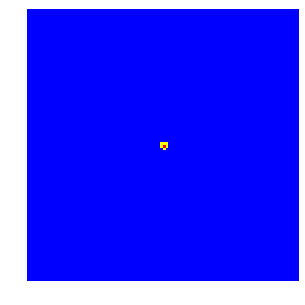

In [119]:
# ---------
# Parameters
payoffs = [1.8, 1, 0, 0]

#t : one player C one player D, D gets t
#r : both players C, they both get r
#p : both defect, both get p
#s : one player C one player D, C gets s
# t>r>p>s

n = 100
prop_c_init = 0.5
rand_seed = None
num_iterations = 100
plot_size_n = 5 # Size of video
num_frames = num_iterations # Number of frames in the video 
special_init = True
# ---------
# Get info

grid_strat_all, grid_colours_all = run_coopsim(payoffs,
                n,
                prop_c_init,
                rand_seed, num_iterations,special_init)


# ---------
# Make video

Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)


fig, ax = plt.subplots(figsize=(plot_size_n, plot_size_n))
plt.axis('off')
anim = animation.FuncAnimation(fig, animate, frames=num_frames, blit=False)

HTML(anim.to_html5_video())

In [122]:
anim.save('coop_1.8_1_0_0_oneit_100its_100squared.mp4')
HTML(anim.to_html5_video()) #[1.8, 1, 0, 0] with one_iteration 100x100 100 its

In [46]:
HTML(anim.to_html5_video()) #[1.9, 1, 0, 0] with one_iteration

In [44]:
HTML(anim.to_html5_video()) #[1.8, 1, 0, 0] with one_iteration

In [41]:
HTML(anim.to_html5_video()) #[1.3, 1, 0, 0] with one_iteration

In [38]:
HTML(anim.to_html5_video()) #[1.3, 1, 0, 0] with one_iteration_alt

In [30]:
HTML(anim.to_html5_video()) #[1.3, 1, 0.5, 0.1] with one_iteration_alt

In [16]:
HTML(anim.to_html5_video()) # [1.3, 1, 0.5, 0.1]

In [19]:
print(HTML(anim.to_html5_video()))

<IPython.core.display.HTML object>
